In [31]:
# package imports
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
smoke_test = ('CI' in os.environ)
import time

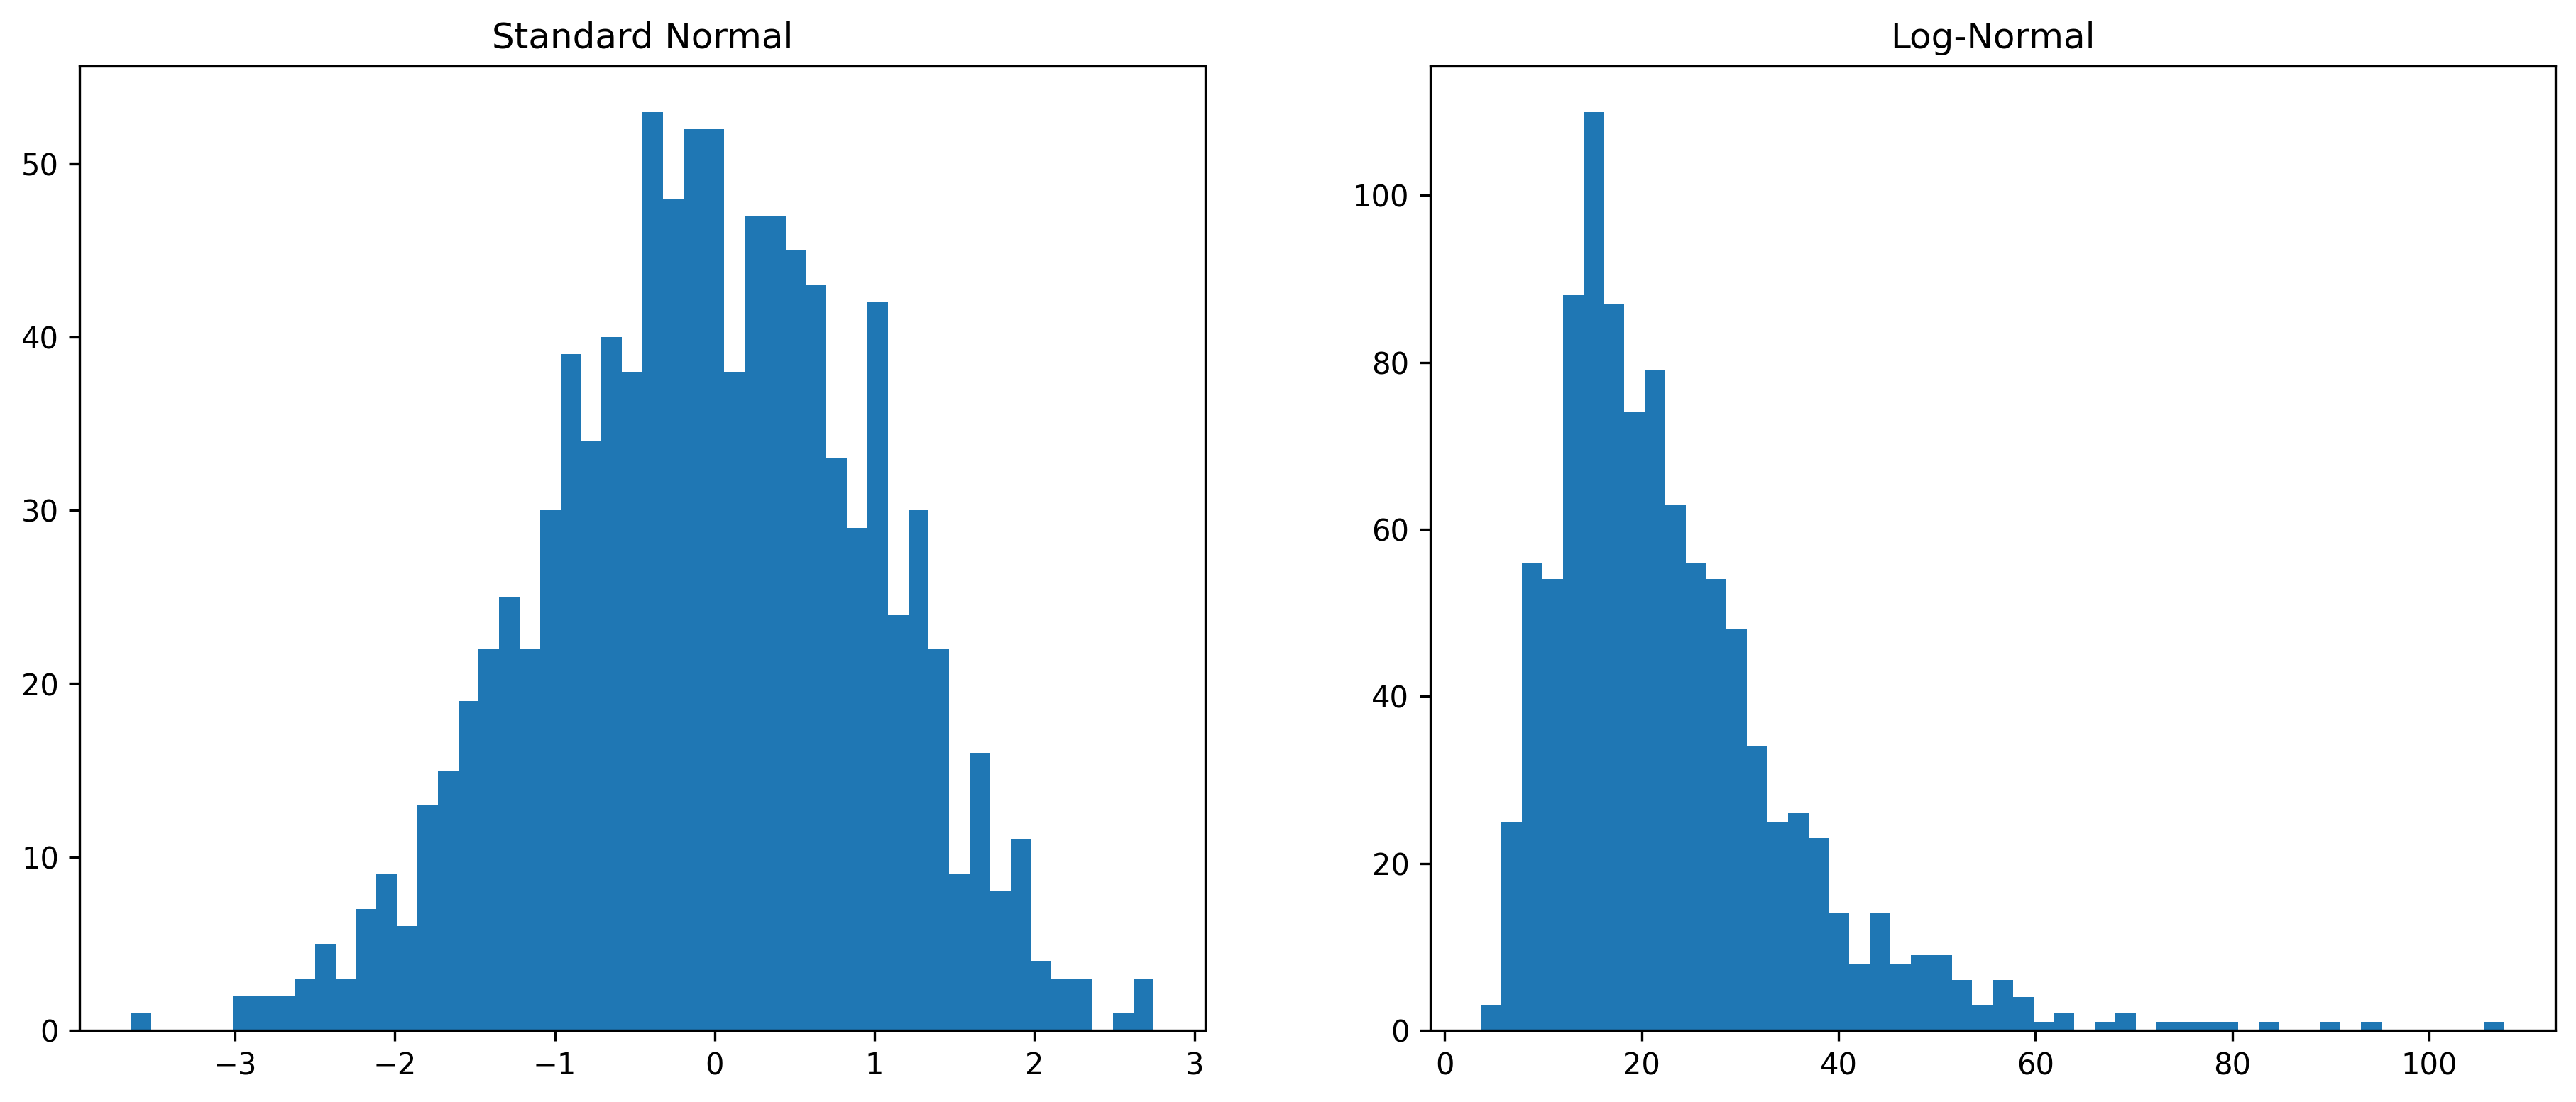

In [19]:
# Define a normal distribution with mean 0 and standard deviation 1 (dist_x)
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))

# Define an affine transform with mean 3 and scale 0.5
affine_transform = T.AffineTransform(loc=3, scale=0.5)

# Define an exponential transform
exp_transform = T.ExpTransform()

# Define a transformed distribution by applying the affine and exponential transforms to dist_x (dist_y)
dist_y = dist.TransformedDistribution(dist_x, [affine_transform, exp_transform])

# Create a figure with two subplots
plt.figure(figsize=(15, 6),dpi=300)
plt.subplot(1, 2, 1)

# Sample 1000 values from dist_x and plot a histogram with 50 bins
plt.hist(dist_x.sample([1000]).numpy(), bins=50)

# Set the title of the first subplot to 'Standard Normal'
plt.title('Standard Normal')

# Create a second subplot
plt.subplot(1, 2, 2)

# Sample 1000 values from dist_y and plot a histogram with 50 bins
plt.hist(dist_y.sample([1000]).numpy(), bins=50)

# Set the title of the second subplot to 'Log-Normal'
plt.title('Log-Normal')

# Display the figure
plt.show()

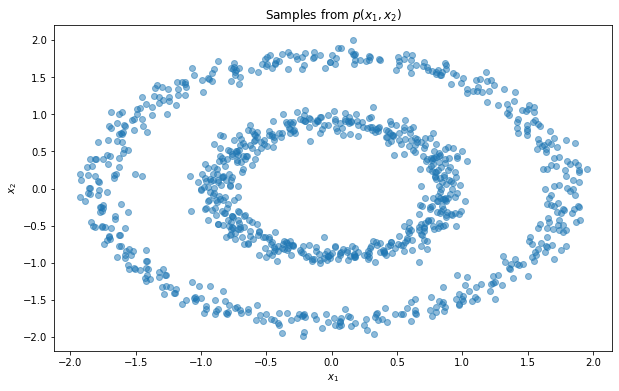

c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


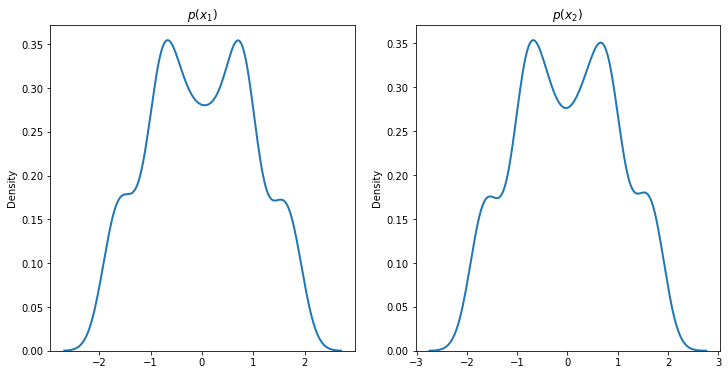

In [27]:
# Import necessary libraries
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# Generate 1000 samples from a circle dataset with a factor of 0.5 and noise of 0.05
n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)

# Standardize the data using StandardScaler
X = StandardScaler().fit_transform(X)

# Create a scatter plot of the samples
plt.figure(figsize=(10, 6))
plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the distribution of x1 in the first subplot
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax=axs[0])
axs[0].set_title(r'$p(x_1)$')

# Plot the distribution of x2 in the second subplot
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             ax=axs[1])
axs[1].set_title(r'$p(x_2)$')

# Display the figure
plt.show()

In [37]:
# Define a base distribution with mean 0 and standard deviation 1 in each dimension (base_dist)
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))

# Define a spline bijector with 16 bins for each dimension (spline_transform)
spline_transform = T.Spline(2, count_bins=16)

# Define a transformed distribution by applying the spline transform to the base distribution (flow_dist)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

In [35]:
# Set the number of optimization steps to 1 if smoke_test is True, otherwise set it to 1001 (steps)
steps = 1 if smoke_test else 1001

# Convert the input data X to a PyTorch tensor (dataset)
dataset = torch.tensor(X, dtype=torch.float)

# Define an Adam optimizer with a learning rate of 0.01 for the spline transform parameters (optimizer)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=1e-2)

# Perform the specified number of optimization steps
for step in range(steps):
    # Zero the gradients of the optimizer
    optimizer.zero_grad()
    
    # Compute the negative log-likelihood of the data under the flow distribution (loss)
    loss = -flow_dist.log_prob(dataset).mean()
    
    # Compute the gradients of the loss with respect to the spline transform parameters
    loss.backward()
    
    # Update the spline transform parameters using the optimizer
    optimizer.step()
    
    # Clear the cache of the flow distribution
    flow_dist.clear_cache()

    # Print the current step and loss every 200 steps
    if step % 200 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 2.8268401622772217
step: 200, loss: 1.2841778993606567
step: 400, loss: 1.2621371746063232
step: 600, loss: 1.2561595439910889
step: 800, loss: 1.2535128593444824
step: 1000, loss: 1.252522587776184


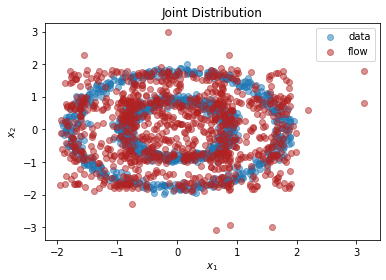

c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
c:\Users\david\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your c

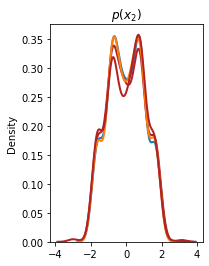

In [36]:
# Generate joint and marginal distribution plots
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()

# Joint distribution plot
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

# Marginal distribution plots
plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')

sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()